# SHG channel

In [46]:
%pylab inline
import skimage.io as io

plt.rcParams['image.cmap'] = 'gray_r'
plt.rcParams['image.interpolation'] = 'none'

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [13]:
img = io.imread('1_66500.png')
img.shape

(512, 512, 3)

In [17]:
files1 = !ls 1_*.png
files2 = !ls 2_*.png

len(files1), len(files2)

(47, 29)

## files with class 1

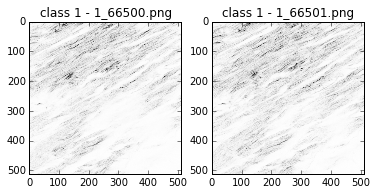

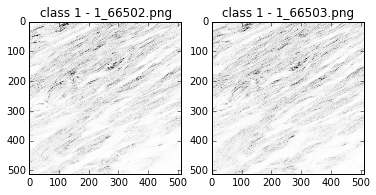

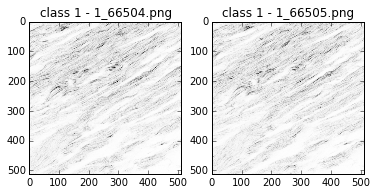

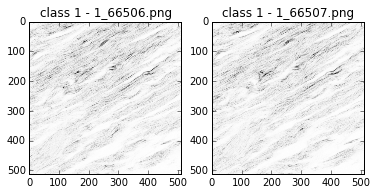

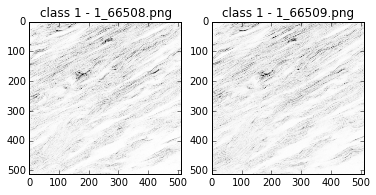

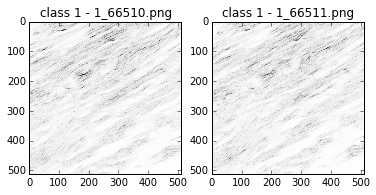

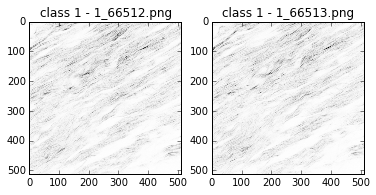

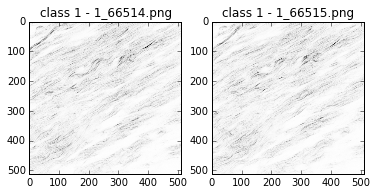

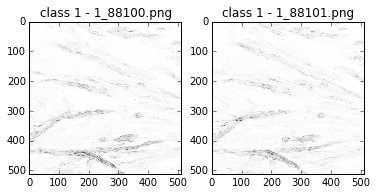

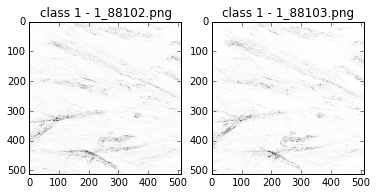

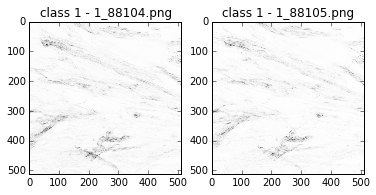

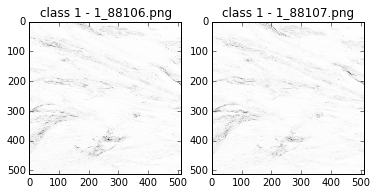

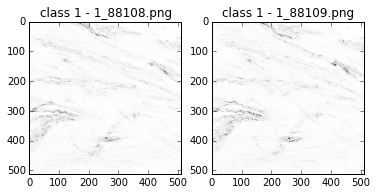

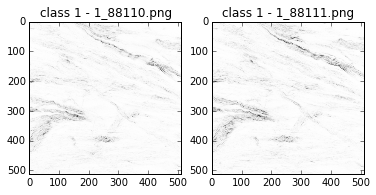

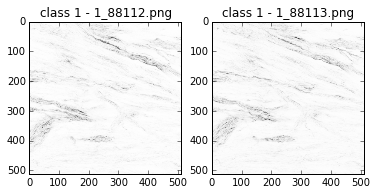

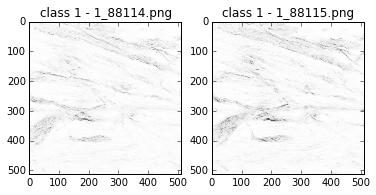

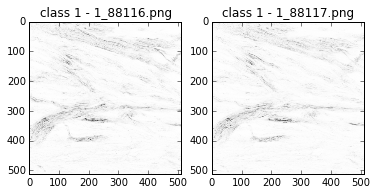

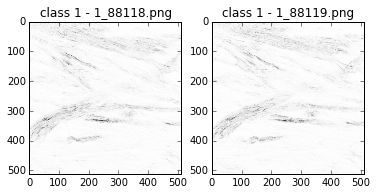

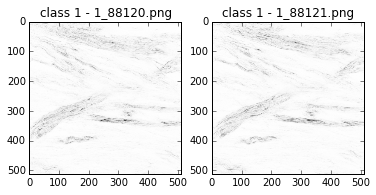

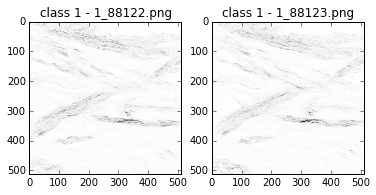

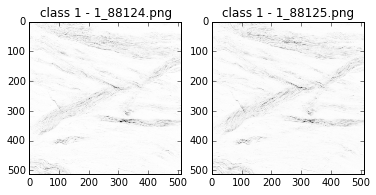

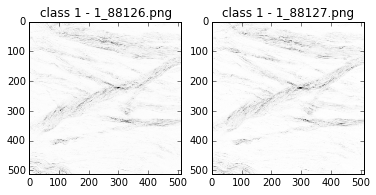

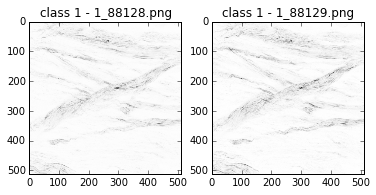

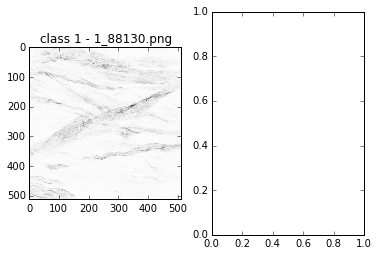

In [18]:
for n, filename in enumerate(files1):
    if n%2 == 0:
        fig, axs = subplots(nrows=1, ncols=2)
    img = io.imread(filename);
    axs[n%2].imshow(img[:,:,0])
    axs[n%2].set_title('class 1 - ' + filename)

## files with class 2

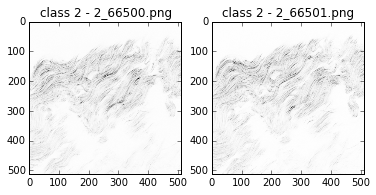

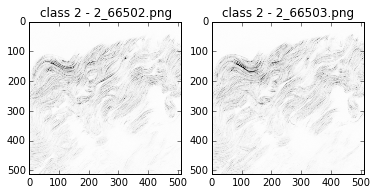

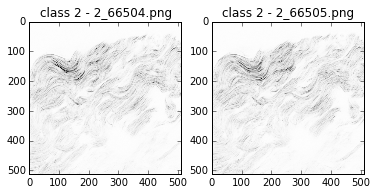

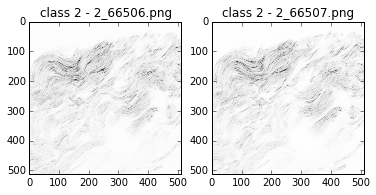

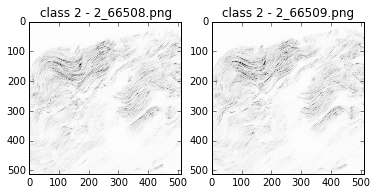

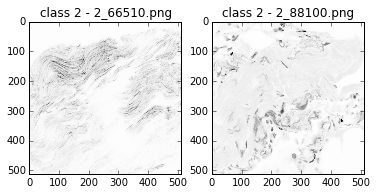

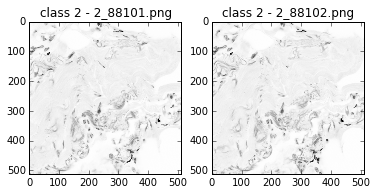

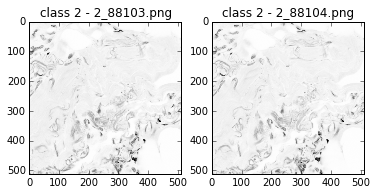

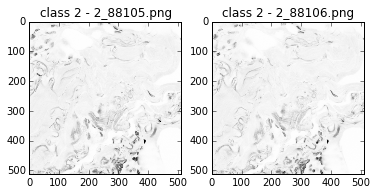

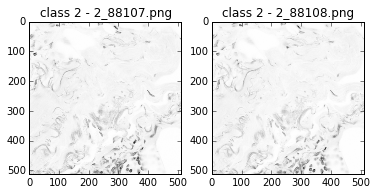

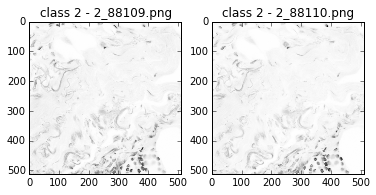

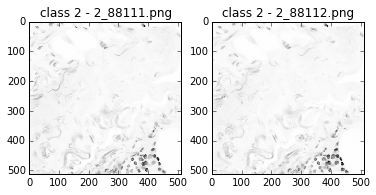

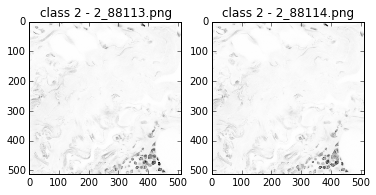

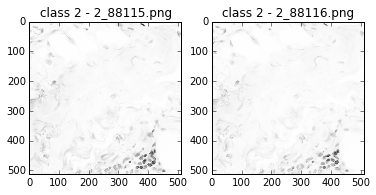

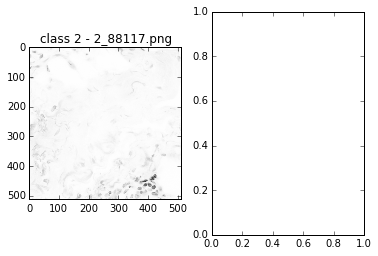

In [19]:
for n, filename in enumerate(files2):
    if n%2 == 0:
        fig, axs = subplots(nrows=1, ncols=2)
    img = io.imread(filename);
    axs[n%2].imshow(img[:,:,0])
    axs[n%2].set_title('class 2 - ' + filename)

Wrong channel for 2_88* ?

In [20]:
img = io.imread('2_88100.png')
img.shape

(512, 512, 3)

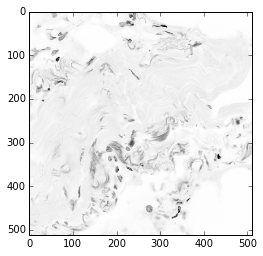

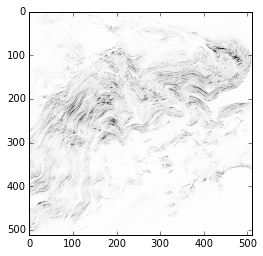

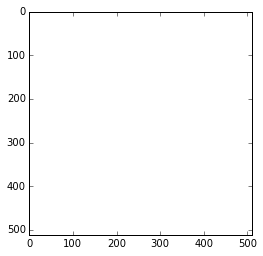

In [22]:
for i in range(3):
    figure()
    imshow(img[:,:,i])

## save files with correct channel as grayscale imgs

In [29]:
%qtconsole

In [25]:
!mkdir original
!mv *.png original

In [41]:
files1 = !ls original/1_*png
files2 = !ls original/2_6*png
files1.extend(files2)
for f in files1:
    img = io.imread(f)[:,:,0]
    io.imsave(f.replace('original/', ''), img);

In [42]:
files2 = !ls original/2_8*png
for f in files2:
    img = io.imread(f)[:,:,1]
    io.imsave(f.replace('original/', ''), img);

# FT algorithm
- Divide picture in subpictures
- Do FT on sub picture
- Analyse FT
- create histogram of angles

## line fit in FT

In [49]:
from skimage.exposure import cumulative_distribution
from scipy.stats import linregress

def angle_ft_line_fit(img, debug=False):
    """
    Calculate preferred orientation in image with a line fit
    in FT.
    
    Parameters
    ----------
    img : ndarray
        Image to do FT and find line fit in FT.
    debug : bool
        If function should show a image for debugging.
            
    Returns
    -------
    (angle, r) : tuple of floats
        Angle of line fit and r value of line fit.
    """
    
    # FT power spectrum
    F = np.abs(fftshift(fft2(img)))
    # do not calculate log(0)
    F[F!=0], F[F==0] = log(F[F!=0]), log(F[F!=0].min())

    # only include top value pixels in FT
    number_of_line_pixels = img.shape[0]//2 # 50% of height
    threshold = number_of_line_pixels / img.size

    # use cdf to find maximum pixels
    cdf = cumulative_distribution(F)
    limit = np.where(cdf[0] > threshold)[0].min()
    threshold_value = cdf[1][limit]
    F = F > threshold_value #binary image

    # points
    y,x = np.where(F)
    # if dy > dx -> swap x,y in line fit for accuracy
    dx = abs(x.max()-x.min())
    dy = abs(y.max()-y.min())
    
    # solve x=my+c by least-squares regression
    if dx < dy:
        m,c,r,pv,err = linregress(y,x)
        b = (1/m, -c/m)
        # calculate angle - assume line goes through center
        angle = (90 - arctan(b[0]) / pi * 180) % 180
    
    # solve y=mx+c by least-squares regression
    else:
        m,c,r,pv,err = linregress(x,y)
        b = (m,c)
        angle = (90 - arctan(b[0]) / pi * 180) % 180

        
    # show image, FT and fit
    if debug:
        f, ax = subplots(ncols=2, figsize=(8,4))
        ax[0].imshow(img)
        ax[1].imshow(F)
        # add calculated line
        # polynomial generator
        p = np.poly1d(b)
        height, width = img.shape
        if angle != 90:
            line = ([0, width], [p(0), p(width)])
        else:
            line = ([width//2, width//2], [0,height])
        ax[1].plot(*line)
        ax[1].set_title('ang: {:3.0f} r:{:0.2} err:{:0.2}'
                        .format(angle,r,err))
        ax[1].set_xlim(0,width)
        ax[1].set_ylim(height,0)

    return (angle, r)

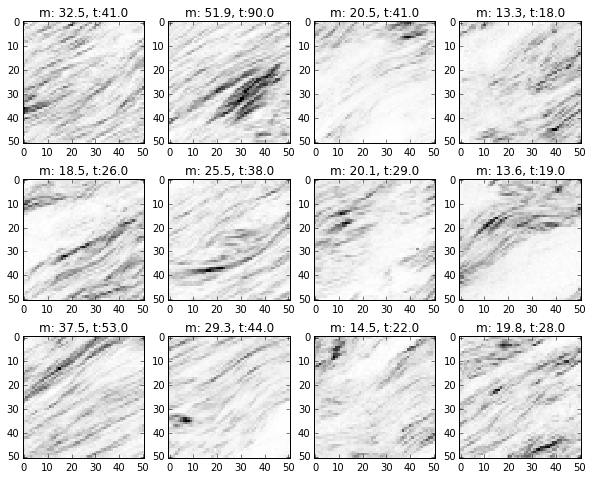

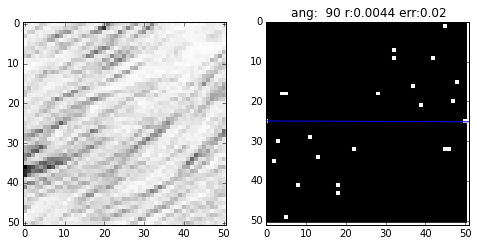

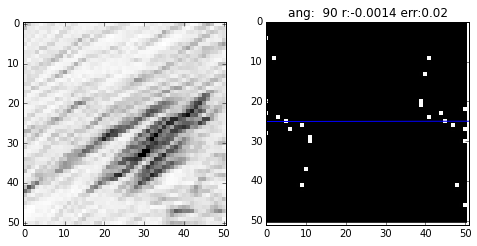

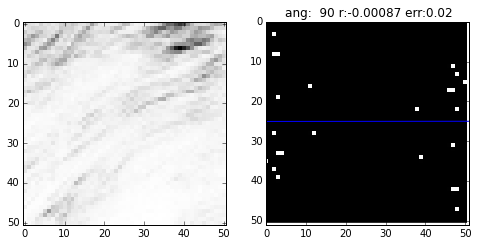

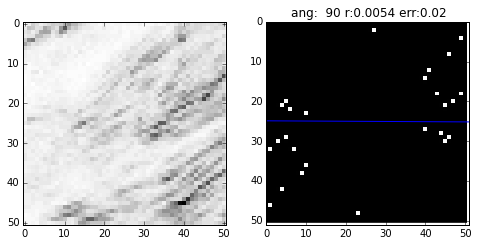

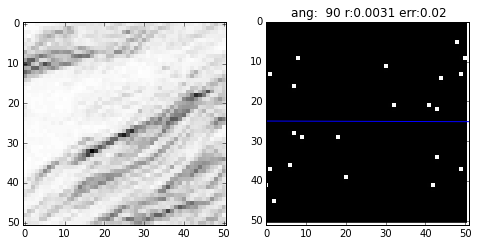

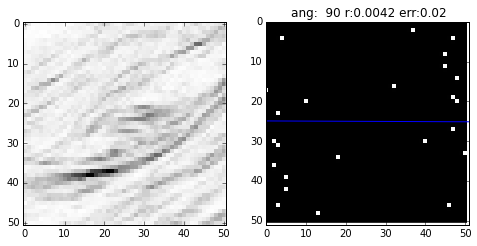

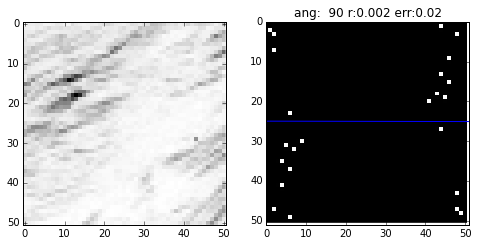

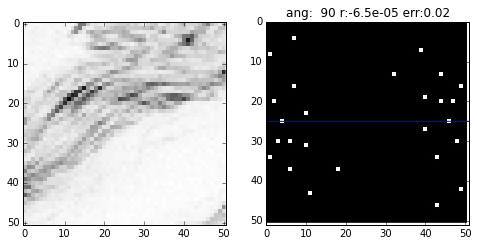

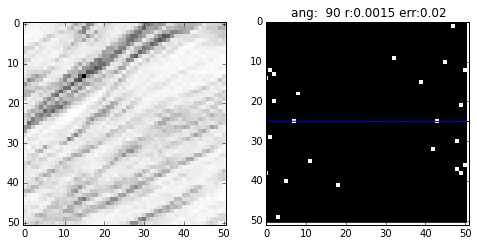

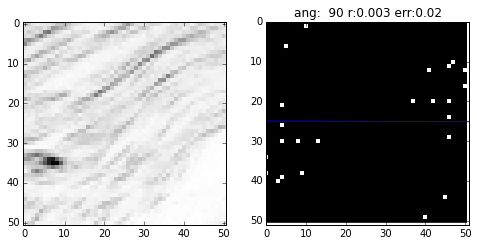

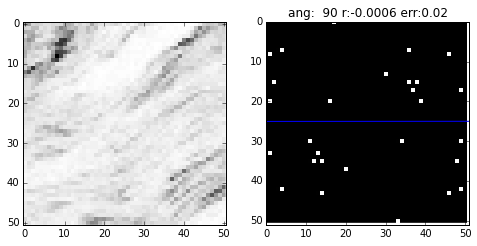

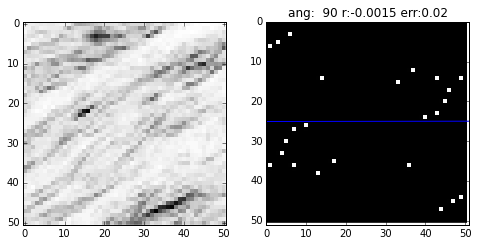

In [47]:
from itertools import product
from skimage.filter import threshold_otsu

h = np.zeros(180)
img = io.imread('1_66500.png')

iy,ix = img.shape
by,bx = (10,10) # number of blocks in x,y direction
bs = img.shape[0] // by
bsy, bsx = iy//by, ix//bx # block size

count = 0
f, axs = subplots(nrows=3, ncols=4, figsize=(10,8))
for j,i in product(range(by), range(bx)):
    x,y = j*bs, i*bs
    temp_img = img[y:y+bs, x:x+bs]
    if temp_img.shape[0] < 50 or temp_img.shape[1] < 50:
        continue
    mean = temp_img.mean()
    if mean <= 0:
        continue
    ot = threshold_otsu(temp_img)
    if ot < 1:
        continue
    if count >= 12:
        break
    if (i < 2 # row
        or i > 40
        or j < 2 #column
        or j > 40):
        continue

    ax = axs[count//4, count%4]
    ax.imshow(temp_img)
    ax.set_title('m: {:1.1f}, t:{:1.1f}'.format(mean, ot))
    count += 1
    if count == 6: # pick out image for manual debug
        ii = np.copy(temp_img)
    angle_ft_line_fit(temp_img, debug=True)